In [1]:
import psycopg2
import sys
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import RegexpTokenizer
from textblob import TextBlob
from __future__ import division

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

In [3]:
def extract_hash_tags(s):
    return set(part[1:] for part in s.split() if part.startswith('#'))


def extract_http(s):
    return set(part for part in s.split() if part.startswith('http'))

In [4]:
def translate(twt):
    lang = twt.detect_language()
    if lang != 'en':
        try:
            return twt.translate(from_lang=lang, to='en')
        except:
            return twt
    else:
        return twt

In [5]:
def get_features(tweet_str):
    twt = TextBlob(tweet_str.decode('utf-8'))
    verblist = list()
    pronlist = list()
    for word, tag in twt.tags:
        if 'VB' in tag:
            verblist.append(word.lemmatize())
        if tag == 'PRP':
            pronlist.append(word.lemmatize())
    try:
        repeat_word_penalty = len(twt.word_counts.values()) / sum(twt.word_counts.values())
    except ZeroDivisionError:
        repeat_word_penalty = 1
    return (twt.sentiment.polarity, twt.sentiment.subjectivity, len(twt.noun_phrases), repeat_word_penalty,
            len(twt.words), len(extract_hash_tags(twt)), len(extract_http(twt)),
            len(verblist), len(pronlist))

In [142]:
'''con = psycopg2.connect("dbname='tweetdat' user='andric'")
sql_query = """
            SELECT rt_tweet, rt_count/user_followers_count::float as rt_influence \
            FROM la_tweets \
            WHERE rt_status = 1 AND user_followers_count > 0 \
            ORDER BY rt_influence DESC LIMIT 136000;
            """
query_results = pd.read_sql_query(sql_query, con)
if con:
    con.close()
'''

In [276]:
query_results = dict()
nodup = dict()
con = psycopg2.connect("dbname='tweetdat' user='andric'")
sql_query = """
            SELECT id, tweet, rt_count/user_followers_count::float as rt_influence, \
            fav_count/user_followers_count::float as fav_influence \
            FROM %s_tweets \
            WHERE rt_count > 1 AND user_followers_count > 1 AND fav_count > 1;
            """
for city in ['la', 'chi', 'hou']:
    query_results[city] = pd.read_sql_query(sql_query % city, con)
if con:
    con.close()

all_tweet_df = pd.concat([query_results['la'], query_results['chi'], query_results['hou']])

all_tweet_df = all_tweet_df.assign(influence = pd.Series(
        all_tweet_df.rt_influence*all_tweet_df.fav_influence),
                                   index=all_tweet_df.index)

all_tweet_df = all_tweet_df.sort('influence', ascending=False)
all_tweet_df = all_tweet_df.drop_duplicates(['tweet']).reset_index(drop=True)

num_tweets = round(all_tweet_df.shape[0] * .75)
num_select = 2*(num_tweets/3)

no_rt_query_results = dict()
nodup = dict()
con = psycopg2.connect("dbname='tweetdat' user='andric'")
sql_query = """
            SELECT id, tweet \
            FROM %s_tweets \
            WHERE user_followers_count > 1 AND rt_count = 0 AND fav_count = 0 \
            LIMIT %d;
            """
for city in ['la', 'chi', 'hou']:
    no_rt_query_results[city] = pd.read_sql_query(sql_query % (city, num_select), con)
if con:
    con.close()

no_rt_all_tweet_df = pd.concat([no_rt_query_results['la'],
                                no_rt_query_results['chi'],
                                no_rt_query_results['hou']])
no_rt_all_tweet_df = no_rt_all_tweet_df.drop_duplicates(['tweet']).reset_index(drop=True)

all_tweet_df = all_tweet_df.iloc[:int(num_tweets), :]
no_rt_all_tweet_df = no_rt_all_tweet_df.sample(n=int(num_tweets))

popular_tweets = all_tweet_df['tweet'].apply(get_features).apply(pd.Series)
nonpopular_tweets = no_rt_all_tweet_df['tweet'].apply(get_features).apply(pd.Series)

In [277]:
#rts_nodups = query_results['rt_tweet'].drop_duplicates()
#popular_tweets = rts_nodups.apply(get_features).apply(pd.Series)

print popular_tweets.shape

(17383, 9)


In [8]:
twt = TextBlob(query_results.iloc[310, :]['rt_tweet'].decode('utf-8'))
twt.detect_language() != 'en'

translate(TextBlob(' '.join(query_results.iloc[8882, :]['rt_tweet'].split()[:2])))

aa = TextBlob("la ila ha ill lalla ho muhammed door rasoolalah")
aa.detect_language()
#aa.translate(from_lang='ar', to='en')

u'ar'

In [11]:
print TextBlob(query_results.iloc[102, :]['rt_tweet'].decode('utf-8'))
print TextBlob(query_results.iloc[102, :]['rt_tweet'].decode('utf-8')).subjectivity

print TextBlob(query_results.iloc[100, :]['rt_tweet'].decode('utf-8'))

No big 💅🏻 https://t.co/ZmzDMiuNR4
0.1
This is my revival https://t.co/B1rouH0ufj


In [9]:
print twt.subjectivity
print twt
#print twt.noun_phrases

0.1
No big 💅🏻 https://t.co/ZmzDMiuNR4


In [10]:
con = psycopg2.connect("dbname='tweetdat' user='andric'")
sql_query = """
            SELECT tweet \
            FROM la_tweets \
            WHERE rt_status = 0 AND user_followers_count > 0
            LIMIT 25000;
            """
query_results = pd.read_sql_query(sql_query, con)
if con:
    con.close()

In [11]:
others_nodups = query_results['tweet'].drop_duplicates()
nonpopular_tweets = others_nodups.apply(get_features).apply(pd.Series)

In [12]:
num_tweets = popular_tweets.shape[0]
nonpopular_tweets = nonpopular_tweets.sample(n=num_tweets)

In [278]:
nonpopular_tweets.mean()

0     0.078339
1     0.282853
2     2.282172
3     0.968792
4    10.481390
5     0.254962
6     0.475752
7     1.599436
8     0.667894
dtype: float64

In [279]:
popular_tweets.mean()

0     0.086034
1     0.306662
2     2.591555
3     0.962234
4    13.000230
5     0.318760
6     0.641086
7     2.040845
8     0.757809
dtype: float64

In [290]:
feat_labels = ['polar', 'subjective', 'numnounphrases', 'repeatwordpenalty',
               'numberwords', 'numberhashtags', 'numberlinks', 'numberverbs', 'numberpnp']
#feat_labels = [feat_labels[i] for i in indices]

popular_tweets.columns = feat_labels
nonpopular_tweets.columns = feat_labels
#num_examples = num_tweets
num_examples = 3000
#num_examples = min(popular_tweets[popular_tweets.numberwords > 1].shape[0],
#                   nonpopular_tweets[nonpopular_tweets.numberwords > 1].shape[0])
y = np.hstack((np.array(num_examples*[1]), np.array(num_examples*[0])))
X = np.vstack((popular_tweets.as_matrix()[:num_examples, :], nonpopular_tweets.as_matrix()[:num_examples, :]))

print num_tweets

17383.0


In [291]:
num_examples

3000

In [292]:
ss = StandardScaler()
ssX = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(ssX, y,
                                                    test_size=0.33)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

In [293]:
y_test.shape

(1980,)

In [294]:
print len(np.where(y_test == 0)[0])
print len(np.where(y_test == 1)[0])

986
994


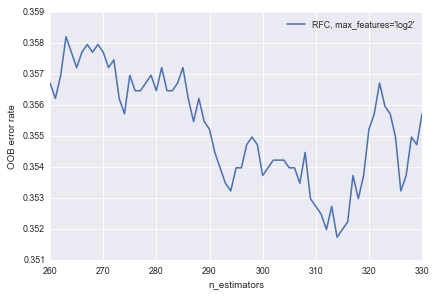

In [295]:
from collections import OrderedDict
RANDOM_STATE = 123
ensemble_clfs = [
    ("RFC, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 260
max_estimators = 330

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
%matplotlib inline
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [299]:
minnum = np.where(error_rate["RFC, max_features='log2'"] == np.array(error_rate["RFC, max_features='log2'"])[:, 1].min())[0][0]
error_rate["RFC, max_features='log2'"][minnum]

(314, 0.35174129353233829)

In [267]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [162]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from time import time

In [300]:
param_dist = {"max_depth": [None],
              "n_estimators": sp_randint(275, 320),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
rf = RandomForestClassifier(max_features='log2')
n_iter_search = 10
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 71.43 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.643 (std: 0.009)
Parameters: {'bootstrap': False, 'min_samples_leaf': 9, 'n_estimators': 290, 'criterion': 'gini', 'min_samples_split': 8, 'max_depth': None}

Model with rank: 2
Mean validation score: 0.643 (std: 0.008)
Parameters: {'bootstrap': False, 'min_samples_leaf': 10, 'n_estimators': 306, 'criterion': 'entropy', 'min_samples_split': 6, 'max_depth': None}

Model with rank: 3
Mean validation score: 0.642 (std: 0.009)
Parameters: {'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 291, 'criterion': 'entropy', 'min_samples_split': 10, 'max_depth': None}



Train/test accuracies: 0.780/0.659
AUC: 0.707092


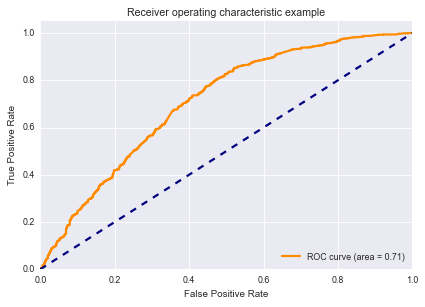

In [301]:
y_train_pred = random_search.best_estimator_.predict(X_train)
y_test_pred = random_search.best_estimator_.predict(X_test)
forest_train = accuracy_score(y_train, y_train_pred)
forest_test = accuracy_score(y_test, y_test_pred)
print('Train/test accuracies: %.3f/%.3f' % (forest_train, forest_test))

#y_train_pred = forest.predict_proba(X_train)[:, 1]
y_test_pred_proba = random_search.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)
print('AUC: %f' % roc_auc)
%matplotlib inline
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('roc_auc_randomseachCV23_6.png', dpi=300)

In [302]:
model = random_search.best_estimator_
print model

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=9,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=290, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [303]:
feat_labels = ['polar', 'subjective', 'numnounphrases', 'repeatwordpenalty', 'numberwords', 'numberhashtags', 'numberlinks', 'numberverbs', 'numberpnp']
#feat_labels = ['polar', 'subjective', 'numberwords']
#forest = RandomForestClassifier(n_estimators=244, n_jobs=-1, criterion='entropy', random_state=1)
forest = random_search.best_estimator_
forest.fit(X_train, y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%3d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
forest_train = accuracy_score(y_train, y_train_pred)
forest_test = accuracy_score(y_test, y_test_pred)
print('Train/test accuracies: %.3f/%.3f' % (forest_train, forest_test))
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
print('AUC: %f' % roc_auc)

  1) numberwords                    0.241249
  2) numberlinks                    0.238019
  3) numnounphrases                 0.098709
  4) subjective                     0.098637
  5) polar                          0.086893
  6) numberverbs                    0.083137
  7) repeatwordpenalty              0.076372
  8) numberpnp                      0.041667
  9) numberhashtags                 0.035318
Train/test accuracies: 0.781/0.663
AUC: 0.662282


In [66]:
rf_okay_model = forest

In [304]:
txt = "dog dog dog"
print forest.predict_proba(ss.fit_transform(np.array(get_features(txt)).reshape(-1,1)).T)
print forest.predict(ss.fit_transform(np.array(get_features(txt)).reshape(-1,1)).T)
print forest.predict_proba(np.array(get_features(txt)).reshape(1, -1))
print forest.predict(np.array(get_features(txt)).reshape(1, -1))

[[ 0.33485707  0.66514293]]
[1]
[[ 0.46088137  0.53911863]]
[1]


In [120]:
print forest.predict_proba(ss.fit_transform(np.array(get_features("dog dog dog")).reshape(-1,1)).T)

[[ 0.35233525  0.64766475]]


In [312]:
from treeinterpreter import treeinterpreter as ti
#txt = "dog blarg desk chair fafe fe fo feature thing hawwfe aeflkj"
txt = " "
#prediction, bias, contributions = ti.predict(forest, np.array(get_features(txt)).reshape(1, -1))
prediction, bias, contributions = ti.predict(forest, ss.fit_transform(np.array(get_features(txt)).reshape(-1,1)).T)
print prediction
print bias

contribs = []
for i in range(len(feat_labels)):
    print (feat_labels[i], contributions[0][i, 1]) 


[[ 0.4890454  0.5109546]]
[[ 0.50099502  0.49900498]]
('Polarity', 0.028119453668917292)
('Subjectivity', 0.029430203112340608)
('# Noun phr', 0.005935791998676835)
('Word dvrs', -0.01025276385164931)
('# Words', 0.079241997335827458)
('Hashtags', -0.0079786506503767719)
('# URLs', -0.13025031664871262)
('# Verbs', 0.0098200022343983753)
('# PRP', 0.0078839041578643819)


In [362]:
"Raise your hand if you still wear a watch! 🙋 #NationalWatchDay http://jcp.is/2sISKyr ".decode('utf-8').decode('utf-8')

UnicodeEncodeError: 'ascii' codec can't encode characters in position 43-44: ordinal not in range(128)

In [190]:
feat_labels[np.argmax(contributions[0][:, 1])]

'numberwords'

In [141]:
from treeinterpreter import treeinterpreter as ti
#txt = "dog blarg desk chair fafe fe fo feature thing hawwfe aeflkj"
txt = "this "
#prediction, bias, contributions = ti.predict(forest, np.array(get_features(txt)).reshape(1, -1))
prediction, bias, contributions = ti.predict(forest, ss.fit_transform(np.array(get_features(txt)).reshape(-1,1)).T)
print prediction
print bias

for i in range(len(feat_labels)):
    print (feat_labels[i], contributions[0][i, 1]) 


[[ 0.42528007  0.57471993]]
[[ 0.49713198  0.50286802]]
('polar', -0.030060880571131317)
('subjective', -0.026987381337950447)
('numnounphrases', 0.0061266392429250175)
('repeatwordpenalty', -0.014408369853058703)
('numberwords', 0.19541291021181384)
('numberhashtags', -9.3129010947255942e-05)
('numberlinks', -0.075688042073486547)
('numberverbs', 0.012939207228241417)
('numberpnp', 0.0046109542759636152)


In [252]:
import seaborn as sns

In [307]:
feat_labels = ['Polarity', 'Subjectivity', '# Noun phr',
               'Word dvrs', '# Words', 'Hashtags',
               '# URLs', '# Verbs', '# PRP']
reordered_labels = []
for f in range(X_train.shape[1]):
    reordered_labels.append(feat_labels[indices[f]])

In [306]:
feat_labelsclean = ['Polarity', 'Subjectivity', '# Noun phr', 'Word dvrs', '# Words', 'Hashtags', '# URLs', '# Verbs', '# PRP']
#feat_labels = ['polar', 'subjective', 'numnounphrases', 'repeatwordpenalty', 'numberwords', 'numberhashtags', 'numberlinks', 'numberverbs', 'numberpnp']


In [197]:
labeldict = dict(zip(feat_labels, feat_labelsclean))

In [199]:
labeldict['numnounphrases']
msgimprv = "You could still increase %s to better your tweet." % labeldict['numnounphrases']
print msgimprv

You could still increase # Noun phr to better your tweet.


/Users/andric/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


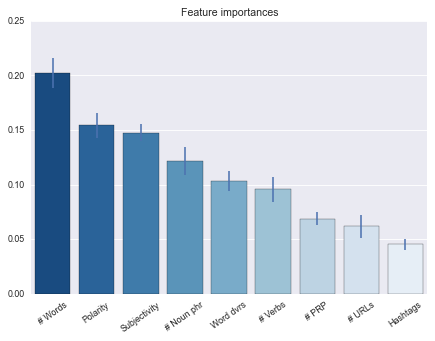

In [31]:
%matplotlib inline
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
sns.set_context("paper")

plt.title("Feature importances")
featbars = sns.barplot(reordered_labels, importances[indices], ci=68, palette="Blues_r", yerr=std[indices])
for item in featbars.get_xticklabels():
    item.set_rotation(35)
featbars.figure.savefig('feature_importances_wk3a.png', dpi=300)

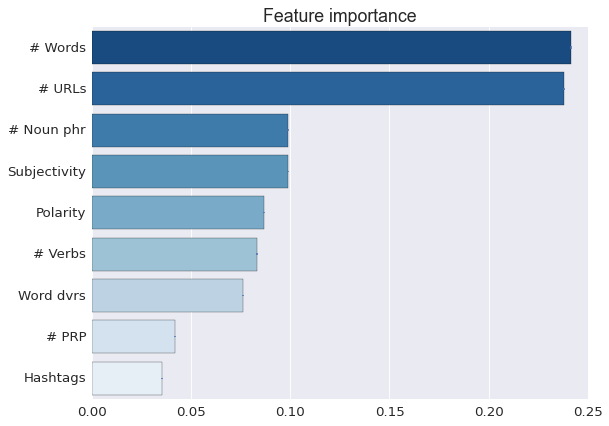

In [308]:
%matplotlib inline
#sns.set(style="whitegrid", context="paper")
sns.set(context="paper")

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
sns.set_context("paper")
plt.figure(figsize=(8, 6))
plt.title("Feature importance", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
featbars = sns.barplot(importances[indices], reordered_labels, ci=68, palette="Blues_r", yerr=std[indices])
#featbars.figure.savefig('feature_importances_wk3a_rot.png', dpi=300)
plt.show()

In [34]:
scores = cross_val_score(forest, X_train, y_train, cv=KFold(10, shuffle=False))
#scores = cross_val_score(estimator=rfc, X=X_train, y=y_train, cv=5, n_jobs=-1)
print('random forest classifier accuracy: %.3f +/- %.3f' % (scores.mean(), scores.std()))

random forest classifier accuracy: 0.623 +/- 0.013


AUC: 0.709308


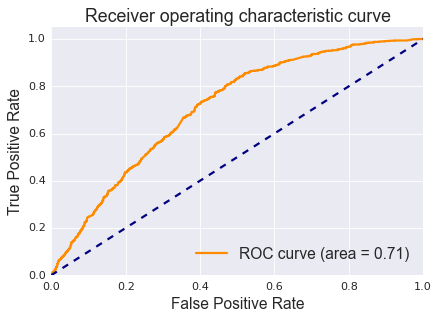

In [309]:
y_train_pred = forest.predict_proba(X_train)[:, 1]
y_test_pred = forest.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
print('AUC: %f' % roc_auc)

y_test_pred = forest.predict_proba(X_test)[:, 1]
#y_train_pred = forest.predict_proba(X_train)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_test_pred)


%matplotlib inline
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('False Positive Rate', {'fontsize': 14})
plt.ylabel('True Positive Rate', {'fontsize': 14})
plt.title('Receiver operating characteristic curve', {'fontsize': 16})
plt.legend(loc="lower right", fontsize=14)
plt.savefig('roc_auc_wk3a.png', dpi=300)
plt.show()

In [564]:
#random_search.best_estimator_.feature_importances_
importances = random_search.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%3d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))


  1) numwords                       0.260580
  2) nounphrases                    0.142261
  3) subjective                     0.115860
  4) links                          0.111025
  5) polar                          0.107712
  6) repeat_pnlty                   0.092059
  7) numberverbs                    0.081098
  8) hashtags                       0.045966
  9) numberpnp                      0.043439


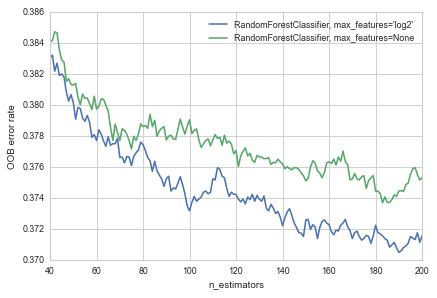

In [625]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
%matplotlib inline
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
#plt.savefig('oob_rf_max_feat.png', dpi=300)

In [462]:
forest.predict_proba(get_features("What an awesome day!"))

/Users/andric/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.22666667,  0.77333333]])

In [463]:
from treeinterpreter import treeinterpreter as ti

prediction, bias, contributions = ti.predict(forest, get_features("What an awesome day!"))

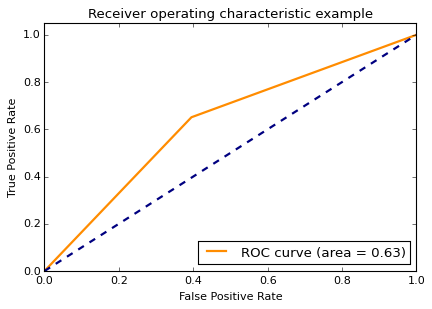

In [386]:
%matplotlib inline
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [302]:
X_train, X_test, y_train, y_test = train_test_split(ssX[:, [0,1,2,3,4]], y,
                                                    test_size=0.33)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

#feat_labels = ['polar', 'subjective', 'numnounphrases', 'repeatwordpenalty', 'numberwords', 'numberhashtags', 'numberlinks', 'numberverbs', 'numberpnp']
feat_labels = ['polar', 'subjective', 'numnounphrases', 'repeatwordpenalty', 'numberwords']
forest = RandomForestClassifier(n_estimators=50, n_jobs=-1, criterion='entropy', random_state=1)
#forest = RandomForestClassifier(n_estimators=100, n_jobs=-1)
forest.fit(X_train, y_train)

importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%3d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
forest_train = accuracy_score(y_train, y_train_pred)
forest_test = accuracy_score(y_test, y_test_pred)
print('Train/test accuracies: %.3f/%.3f' % (forest_train, forest_test))
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
print('AUC: %f' % roc_auc)

  1) polar                          0.261884
  2) subjective                     0.237547
  3) numberwords                    0.233372
  4) numnounphrases                 0.157029
  5) repeatwordpenalty              0.110168
Train/test accuracies: 0.808/0.581
AUC: 0.581393


In [224]:
from xgboost import XGBClassifier

In [226]:
#X_train, X_test, y_train, y_test = train_test_split(ssX, y, test_size=0.2)

model = XGBClassifier()
model.fit(X_train, y_train)

#feat_labels = ['polar', 'subjective', 'numberwords', 'numberverbs', 'numberpnp']
#feat_labels = ['polar', 'subjective', 'repeatwordpenalty', 'numberwords', 'numberhashtags', 'numberlinks', 'numberverbs', 'numberpnp']
feat_labels = ['polar', 'subjective', 'numnounphrases', 'repeatwordpenalty', 'numberwords', 'numberhashtags', 'numberlinks', 'numberverbs', 'numberpnp']
#feat_labels = ['polar', 'subjective', 'numberwords', 'numberhashtags', 'numberlinks']
#feat_labels = ['polar', 'subjective', 'numberwords']

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%3d) %-*s %f" % (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
model_train = accuracy_score(y_train, y_train_pred)
model_test = accuracy_score(y_test, y_test_pred)
print('Train/test accuracies: %.3f/%.3f' % (model_train, model_test))
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)
print('AUC: %f' % roc_auc)

  1) numberwords                    0.234177
  2) polar                          0.155063
  3) numnounphrases                 0.134494
  4) subjective                     0.113924
  5) repeatwordpenalty              0.098101
  6) numberlinks                    0.093354
  7) numberverbs                    0.083861
  8) numberhashtags                 0.044304
  9) numberpnp                      0.042722
Train/test accuracies: 0.693/0.640
AUC: 0.640561


In [43]:
print(model.feature_importances_)

[ 0.24962178  0.21785174  0.2859304   0.16187595  0.08472012]


In [305]:
from sklearn.externals import joblib

In [387]:
joblib.dump(forest, 'model_dir/forest_model.sav')

['model_dir/forest_model.sav']

In [328]:
#forest.predict_proba(X_test[0, :].reshape(1, -1))
forest.predict_proba(get_features(" n"))

/Users/andric/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.25,  0.75]])

In [323]:
forest.classes_

array([0, 1])

In [388]:
rfmodel = joblib.load('model_dir/forest_model.sav')

In [403]:
rfmodel.predict(X_test[0, :].reshape(1, -1))[0]

0

In [394]:
X_test[0, :].reshape(1, -1)

array([[-1.34731558,  0.98412888,  0.2234066 ,  0.57105414,  0.49096607,
         3.88199092, -1.12322421,  0.07581134, -0.64647157]])

In [404]:
rfmodel.predict(get_features('no'))

/Users/andric/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([0])

In [14]:
from nltk.corpus import twitter_samples

In [15]:
twitter_samples.fileids()

[u'negative_tweets.json',
 u'positive_tweets.json',
 u'tweets.20150430-223406.json']

In [419]:
twitter_samples.tokenized('tweets.20150430-223406.json')

NameError: name 'twitter_samples' is not defined

In [543]:
y.shape

(29082,)

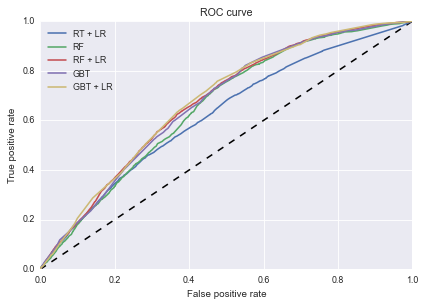

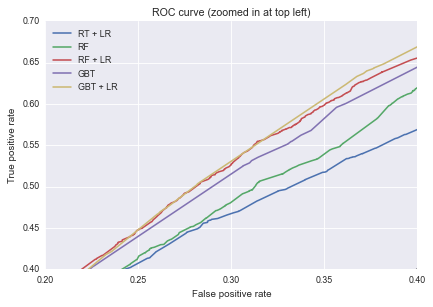

In [544]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline

n_estimator = 10
#X, y = make_classification(n_samples=80000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
# It is important to train the ensemble of trees on a different subset
# of the training data than the linear regression model to avoid
# overfitting, in particular if the total number of leaves is
# similar to the number of training samples
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.5)

# Unsupervised transformation based on totally random trees
rt = RandomTreesEmbedding(max_depth=3, n_estimators=n_estimator,
    random_state=0)

rt_lm = LogisticRegression()
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X_train, y_train)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
rf_enc = OneHotEncoder()
rf_lm = LogisticRegression()
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)

y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegression()
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)


# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)


# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.2, 0.4)
plt.ylim(0.4, 0.7)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [79]:
nonpopular_tweets.columns = [feat_labels]
popular_tweets.columns = [feat_labels]


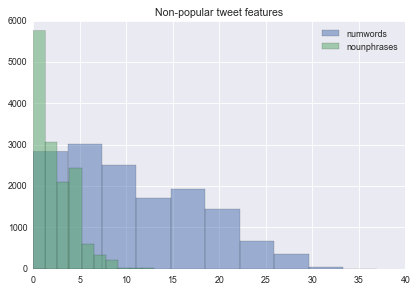

In [571]:
plt.figure()
plt.xlim(0, 40)
plt.title("Non-popular tweet features")
plt.hist(nonpopular_tweets.numwords.values, alpha=0.5, label=feat_labels[4])
plt.hist(nonpopular_tweets.nounphrases.values, alpha=0.5, label=feat_labels[2])
#plt.hist(popular_tweets.subjective.values, alpha=0.5, label=feat_labels[1])
#plt.hist(popular_tweets.links.values, alpha=0.5, label=feat_labels[6])
plt.legend()
#plt.show()
plt.savefig('wk3_nonpopxfactor_hist.png', dpi=300)

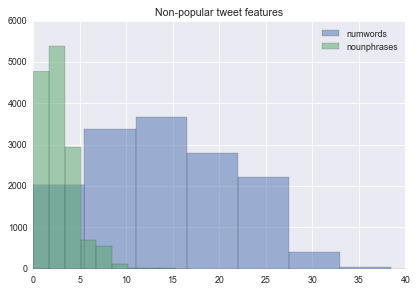

In [570]:
plt.figure()
plt.xlim(0, 40)
plt.title("Non-popular tweet features")
plt.hist(popular_tweets.numwords.values, alpha=0.5, label=feat_labels[4])
plt.hist(popular_tweets.nounphrases.values, alpha=0.5, label=feat_labels[2])
#plt.hist(popular_tweets.subjective.values, alpha=0.5, label=feat_labels[1])
#plt.hist(popular_tweets.links.values, alpha=0.5, label=feat_labels[6])
plt.legend()
#plt.show()
plt.savefig('wk3_popxfactor_hist.png', dpi=300)

In [73]:
feat_labels

['Polarity',
 'Subjectivity',
 '# Noun phr',
 'Word dvrs',
 '# Words',
 'Hashtags',
 '# URLs',
 '# Verbs',
 '# PRP']

In [574]:
from scipy.stats import ks_2samp

In [575]:
ks_2samp(popular_tweets.numwords.values, nonpopular_tweets.numwords.values)

(0.17089608692662128, 2.1936662470423394e-185)

In [77]:
feat_labels = ['polar', 'subjective', 'numnounphrases', 'repeatwordpenalty', 'numberwords', 'numberhashtags', 'numberlinks', 'numberverbs', 'numberpnp']

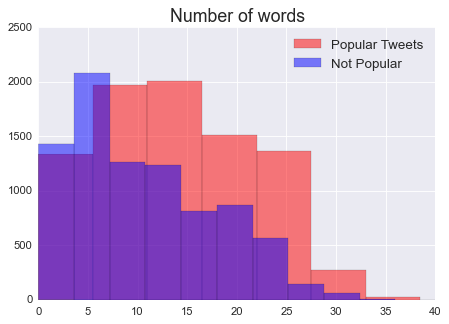

In [85]:
plt.figure()
plt.xlim(0, 40)
plt.title("Number of words", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.hist(popular_tweets.numberwords.values, alpha=0.5, label='Popular Tweets', color='red')
plt.hist(nonpopular_tweets.numberwords.values, alpha=0.5, label='Not Popular', color='blue')
#plt.hist(popular_tweets.subjective.values, alpha=0.5, label=feat_labels[1])
#plt.hist(popular_tweets.links.values, alpha=0.5, label=feat_labels[6])
plt.legend(fontsize=12)
plt.savefig('wk3_numwords_hist.png', dpi=300)

(0.090571487518052385, 2.2374339378889741e-52)


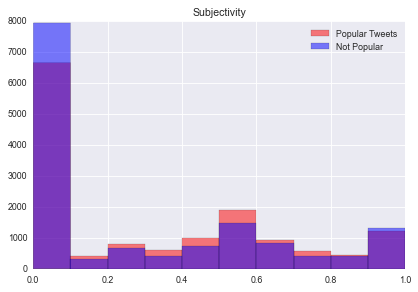

In [585]:
print ks_2samp(popular_tweets.subjective.values, nonpopular_tweets.subjective.values)
plt.figure()
#plt.xlim(0, 40)
plt.title("Subjectivity")
plt.hist(popular_tweets.subjective.values, alpha=0.5, label='Popular Tweets', color='red')
plt.hist(nonpopular_tweets.subjective.values, alpha=0.5, label='Not Popular', color='blue')
#plt.hist(popular_tweets.subjective.values, alpha=0.5, label=feat_labels[1])
#plt.hist(popular_tweets.links.values, alpha=0.5, label=feat_labels[6])
plt.legend()
plt.savefig('wk3_subjective_hist.png', dpi=300)

(0.05171583797537993, 2.307268421051638e-17)


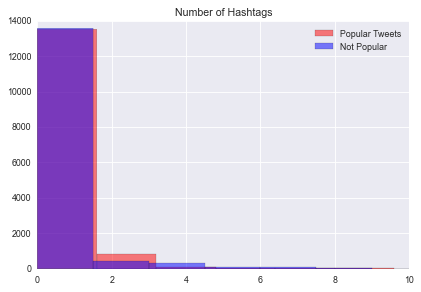

In [588]:
print ks_2samp(popular_tweets.hashtags.values, nonpopular_tweets.hashtags.values)
plt.figure()
plt.xlim(0, 10)
plt.title("Number of Hashtags")
plt.hist(popular_tweets.hashtags.values, alpha=0.5, label='Popular Tweets', color='red')
plt.hist(nonpopular_tweets.hashtags.values, alpha=0.5, label='Not Popular', color='blue')
plt.legend()
plt.savefig('wk3_hashtags_hist.png', dpi=300)

(0.070559108727047737, 5.9069082717832136e-32)


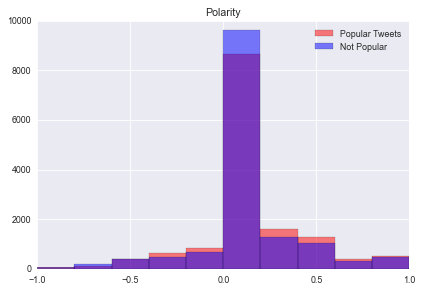

In [589]:
print ks_2samp(popular_tweets.polar.values, nonpopular_tweets.polar.values)
plt.figure()
#plt.xlim(0, 40)
plt.title("Polarity")
plt.hist(popular_tweets.polar.values, alpha=0.5, label='Popular Tweets', color='red')
plt.hist(nonpopular_tweets.polar.values, alpha=0.5, label='Not Popular', color='blue')
plt.legend()
plt.savefig('wk3_polarity_hist.png', dpi=300)

(0.070559108727047737, 5.9069082717832136e-32)


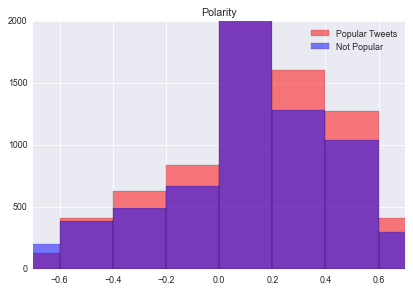

In [590]:
print ks_2samp(popular_tweets.polar.values, nonpopular_tweets.polar.values)
plt.figure()
plt.xlim(-0.7, 0.7)
plt.ylim(0, 2000)
plt.title("Polarity")
plt.hist(popular_tweets.polar.values, alpha=0.5, label='Popular Tweets', color='red')
plt.hist(nonpopular_tweets.polar.values, alpha=0.5, label='Not Popular', color='blue')
plt.legend()
plt.savefig('wk3_zoompolarity_hist.png', dpi=300)

In [447]:
TextBlob("Take an amazing warrior to see your hero this #FathersDay").noun_phrases

WordList([u'amazing warrior', 'fathersday'])

In [445]:
TextBlob("I like singing in the bath.").noun_phrases

WordList([])